In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.utils import shuffle
from grid_search_train import grid_search
from catboost import CatBoostClassifier

In [2]:

workDir = 'D:/LAB/放鬆-三總/Relaxing/分析'
os.chdir(workDir)


In [3]:
def getData(dataset):
    # 'Fusion_AA'、'Fusion_NN'、'Fusion_ANpre'、'Fusion_ANpost'
    if dataset.split('_')[0].lower() == 'fusion' :
        return pd.read_csv("Feature/%s_feature.csv"%(dataset), index_col=0)
    else:
        return pd.read_csv('Feature/%s.csv'%(dataset), index_col=0)

In [4]:
# def getData(dataset):
#     if dataset.lower() == 'fusion' :
#         dataHRV = pd.read_csv('Feature/HRV.csv', index_col=0)
#         dataGSR = pd.read_csv('Feature/GSR.csv', index_col=0)
#         dataRES = pd.read_csv('Feature/RES.csv', index_col=0)
#         dataEEG = pd.read_csv('Feature/EEG.csv', index_col=0)

#         # Get overlapping columns
#         overlapping_columns = set(dataHRV.columns) & set(dataGSR.columns) & set(dataRES.columns) & set(dataEEG.columns)
#         overlapping_columns.remove('data_name')  # We don't want to remove the merging key

#         # Drop overlapping columns from some datasets
#         dataGSR = dataGSR.drop(columns=overlapping_columns)
#         dataRES = dataRES.drop(columns=overlapping_columns)
#         dataEEG = dataEEG.drop(columns=overlapping_columns)

#         # Merging datasets
#         data = pd.merge(dataHRV, dataGSR, on='data_name', how='inner')
#         data = pd.merge(data, dataRES, on='data_name', how='inner')
#         data = pd.merge(data, dataEEG, on='data_name', how='inner')

#         # Remove duplicates
#         data = data.loc[~data.index.duplicated(keep='first')]
#         data.to_csv("Data/Feature/fusion_feature.csv")

#         return data

#     else:
#         return pd.read_csv('Feature/%s.csv'%(dataset), index_col=0)

In [5]:
def diffBetweenTrainingCount(data, g1, g2=None):
    if 'trainingCount' in g1:
        group1 = data[data['trainingCount'] == g1['trainingCount']]
    else:
        group1 = data

    group1 = group1[group1['addictLabel'] == g1['addictLabel']]
    # group1 = group1[group1['stateLabel'] == g1['stateLabel']].drop(['data_name', 'addictLabel', 'stateLabel', 'trainingCount'], axis=1).to_numpy()
    group1 = group1[group1['stateLabel'] == g1['stateLabel']].drop(['data_name', 'addictLabel', 'stateLabel'], axis=1).to_numpy()

    if g2:
        if 'trainingCount' in g2:
            group2 = data[data['trainingCount'] == g2['trainingCount']]
        else:
            group2 = data

        group2 = group2[group2['addictLabel'] == g2['addictLabel']]
        # group2 = group2[group2['stateLabel'] == g2['stateLabel']].drop(['data_name', 'addictLabel', 'stateLabel', 'trainingCount'], axis=1).to_numpy()
        group2 = group2[group2['stateLabel'] == g2['stateLabel']].drop(['data_name', 'addictLabel', 'stateLabel'], axis=1).to_numpy()
        data = group2 - group1
    else:
        data = group1

    return data

In [6]:
def createDataName(dataset, group1_1, group1_2, group2_1, group2_2, featureSelectModelName):
    dataName = ''
    dataName += dataset + '_'
    dataName +=  'A' if group1_1['addictLabel'] == 1 else 'N'

    if 'trainingCount' in group1_1:
        dataName += str(group1_1['trainingCount'])

    if group1_2 and 'trainingCount' in group1_2:
        dataName += str(group1_2['trainingCount'])

    if group2_1['addictLabel'] == 0:
        dataName += 'N'
    else:
        dataName += 'A'
        if 'trainingCount' in group2_1:
            dataName += str(group2_1['trainingCount'])

    if group2_2 and 'trainingCount' in group2_2:
        dataName += str(group2_2['trainingCount'])

    state_label_mapping = {0: 'pre', 1: 'vr', 2: 'post'}
    stage = state_label_mapping[group1_1['stateLabel']]
    stage2 = state_label_mapping[group2_1['stateLabel']]
    dataName += '_' + stage + '_' + stage2 + '_' + featureSelectModelName if featureSelectModelName != None else '_' + stage + '_' + stage2

    dataName += '.csv'
    return dataName


In [7]:
def trainModel(dataset, group1_1, group1_2, group2_1, group2_2,featureSelectModel=None,isleave_one=True):
    data = getData(dataset)
    data = data.drop_duplicates()

    x1 = diffBetweenTrainingCount(data, group1_1, group1_2)
    y1 = [0 for _ in range(0, len(x1))]

    x2 = diffBetweenTrainingCount(data, group2_1, group2_2)
    y2 = [1 for _ in range(0, len(x2))]

    X_train = np.concatenate([x1, x2])
    y_train = y1+y2

    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    
    dataName = createDataName(dataset, group1_1, group1_2, group2_1, group2_2, type(featureSelectModel).__name__ if featureSelectModel != None else None)
    print(dataName)
    
    try:
        best_para = grid_search(X_train, y_train, leave_one=isleave_one,testSize=0.2,selectModel=featureSelectModel)#, title='HRV_prepost_DT', paraPath="Data/modelResult/")
        best_para.to_csv("Data/ModelResult/%s"%(dataName))
    except ValueError as e:
        # 如果上述代碼塊產生ValueError，則會執行這個代碼塊
        print(dataName,"有問題無法執行")
        print("錯誤訊息",e)

    

    return dataName



In [32]:
#datasets = ['GSR','RES','HRV','EEG_bandMean','fusion']
# datasets = ['EEG'、'EEG_PCR'、'GSR'、'HRV'、'RES_dc'、'Fusion'、'Fusion_AA'、'Fusion_NN'、'Fusion_ANpre'、'Fusion_ANpost'、'Fusion_AA_Effect'、'Fusion_NN_Effect'、'Fusion_ANpre_Effect'、'Fusion_ANpost_Effect']   dc:drop column
datasets = ['Fusion_ANpost_Effect']
# selectModels = [None,LogisticRegression(),DecisionTreeClassifier(),LinearSVC(),CatBoostClassifier()]
selectModels = [None]

Fusion_ANpost_Effect_AN_post_post.csv
test with leave one out


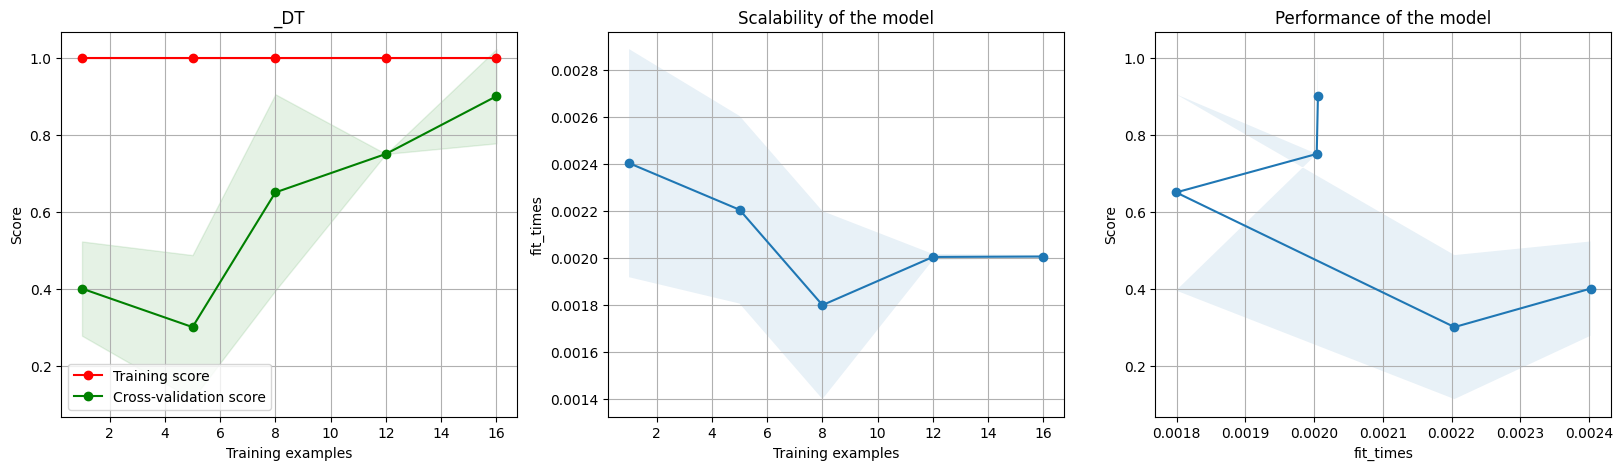

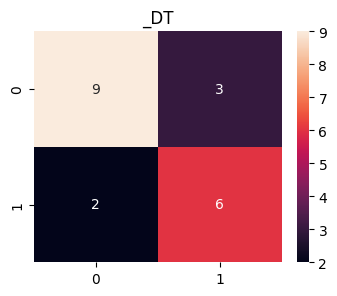

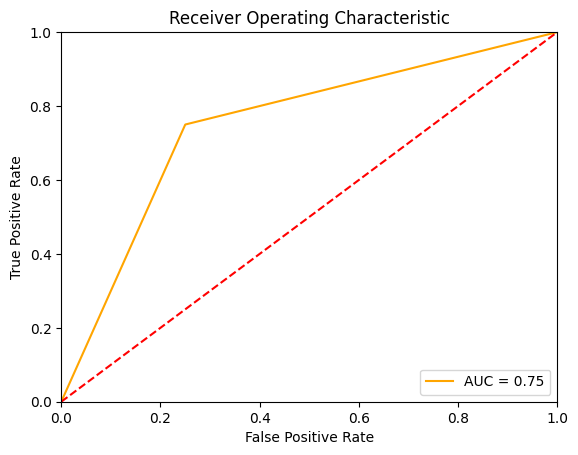

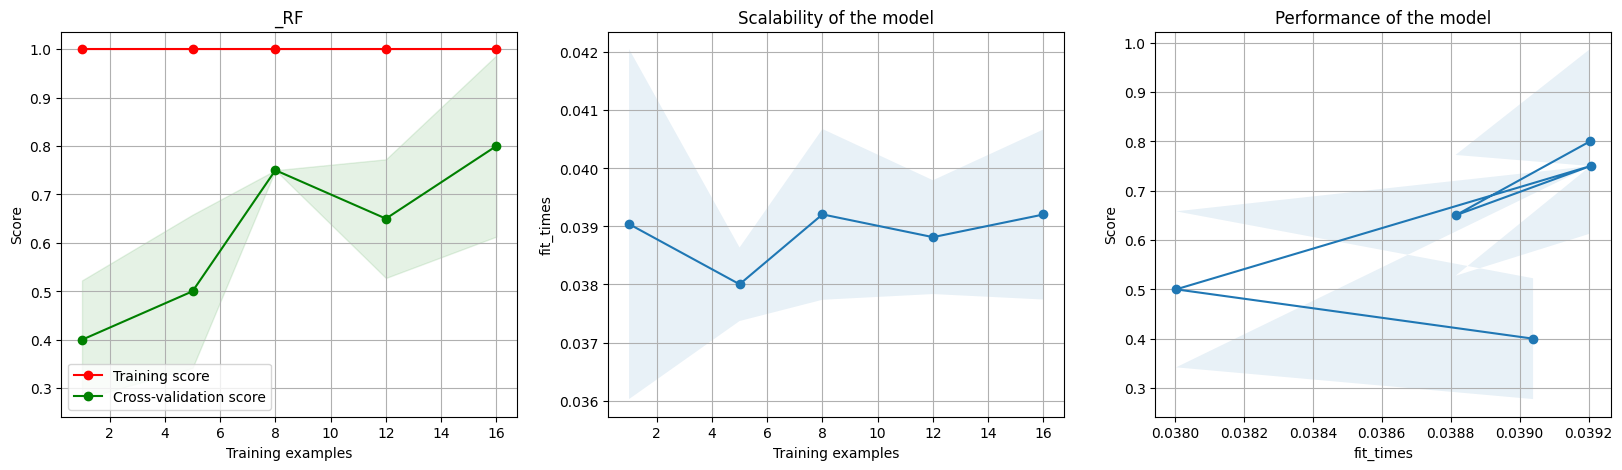

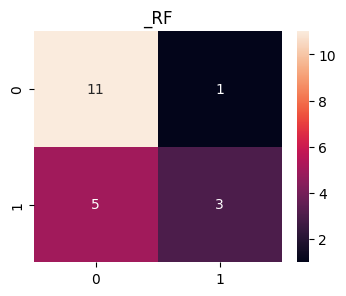

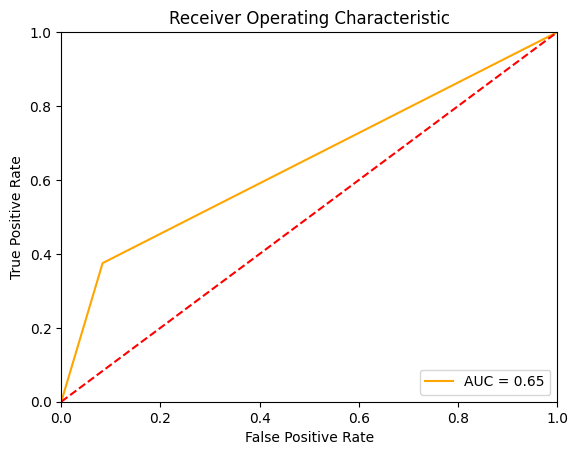

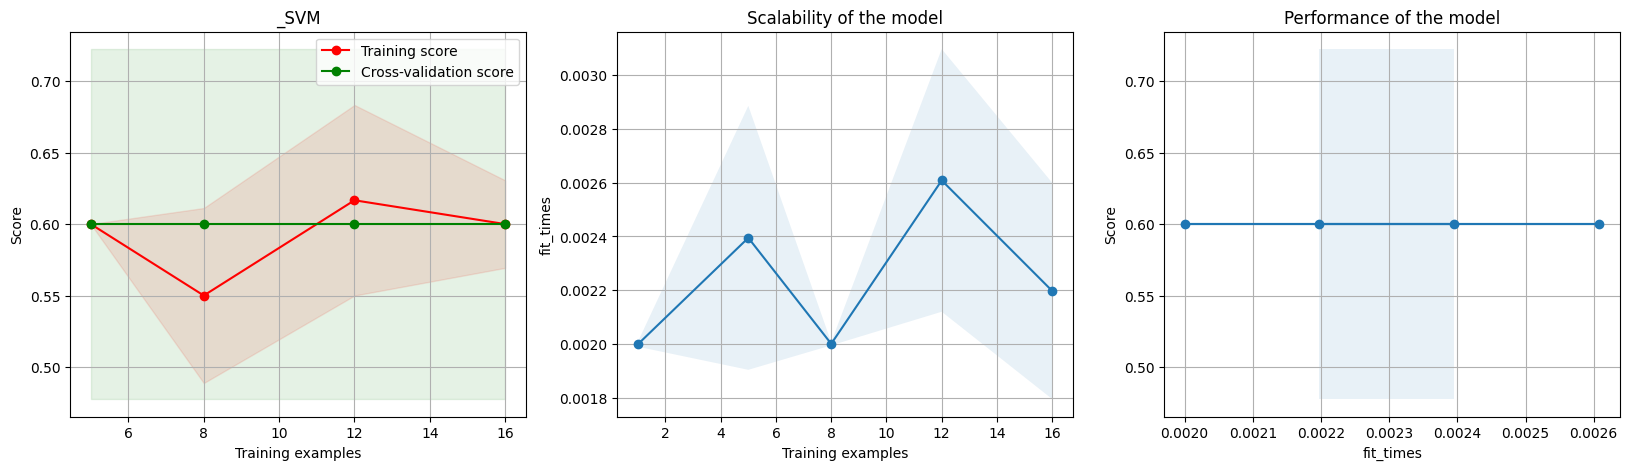

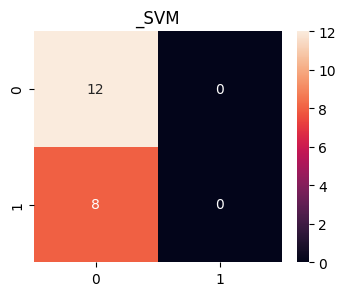

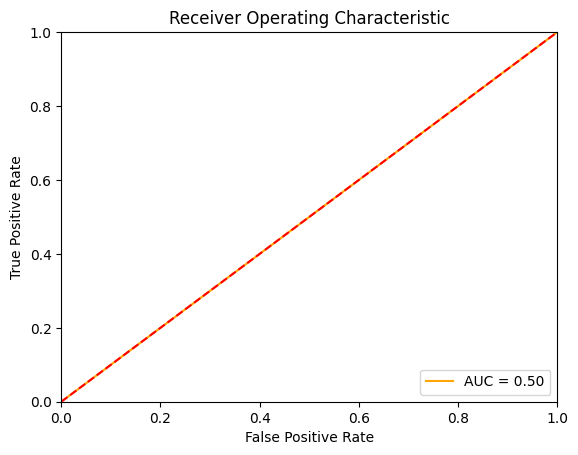

d:\LAB\放鬆-三總\Relaxing\分析\grid_search_train.py:42: RuntimeWarning: invalid value encountered in scalar divide
  result['Precision'] = TP/(TP+FP)


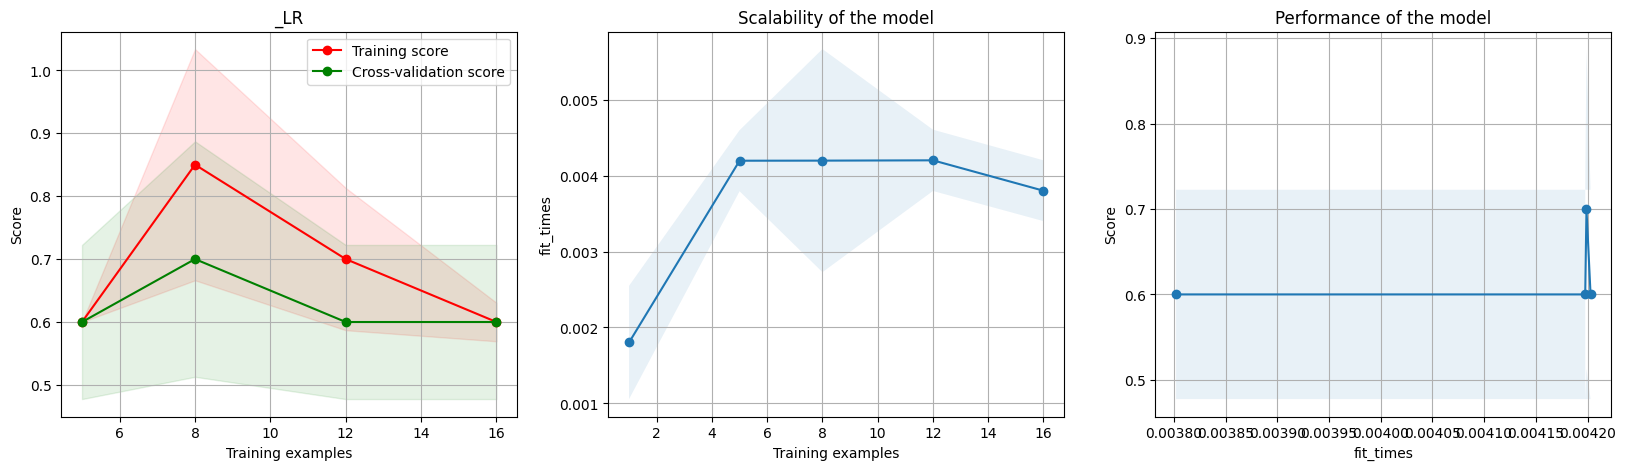

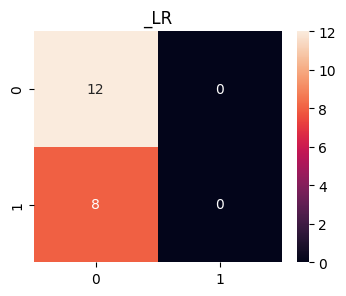

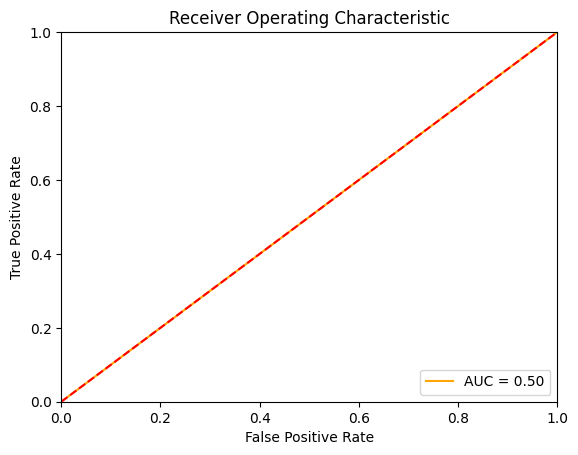

d:\LAB\放鬆-三總\Relaxing\分析\grid_search_train.py:42: RuntimeWarning: invalid value encountered in scalar divide
  result['Precision'] = TP/(TP+FP)


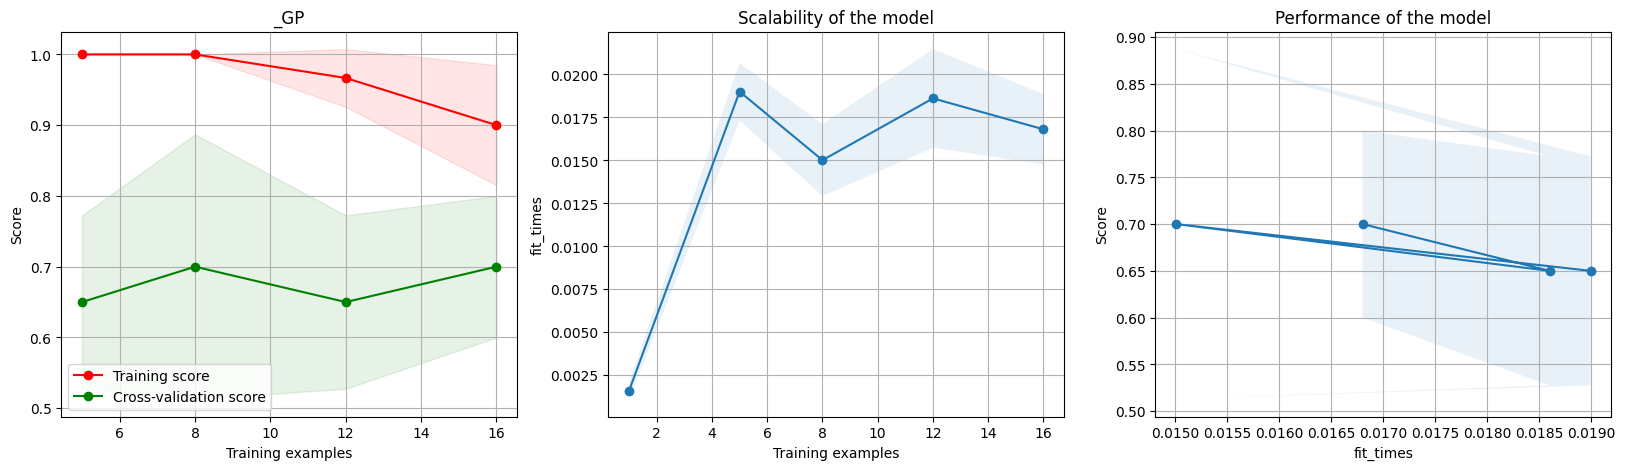

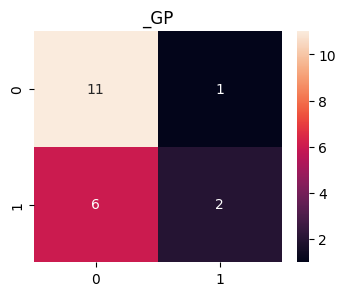

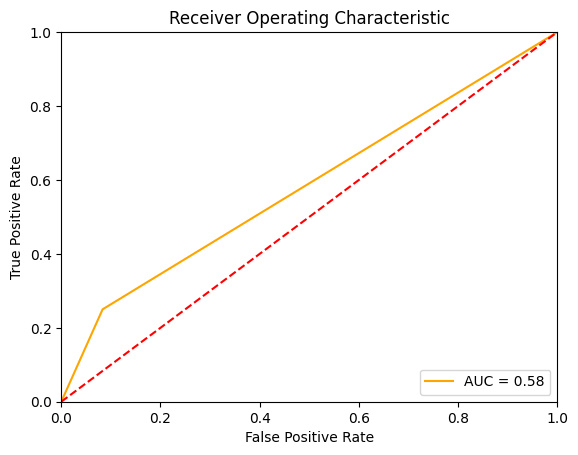

c:\Users\WMlab\.pyenv\pyenv-win\versions\3.11.4\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.6  0.6  0.8  0.8  0.6  0.7  0.6  0.7  0.65 0.7  0.65 0.75 0.75 0.6
 0.75 0.7  0.65 0.75 0.65 0.75 0.6  0.65 0.6  0.55 0.6  0.6  0.6  0.6
 0.6  0.6   nan  nan  nan  nan  nan  nan 0.6  0.6  0.8  0.8  0.6  0.7
 0.6  0.7  0.65 0.7  0.65 0.75 0.75 0.6  0.75 0.7  0.65 0.75 0.65 0.75
 0.6  0.65 0.6  0.55 0.6  0.6  0.6  0.6  0.6  0.6   nan  nan  nan  nan
  nan  nan 0.6  0.6  0.8  0.8  0.6  0.7  0.6  0.7  0.65 0.7  0.65 0.75
 0.75 0.6  0.75 0.7  0.65 0.75 0.65 0.75 0.6  0.65 0.6  0.55 0.6  0.6
 0.6  0.6  0.6  0.6   nan  nan  nan  nan  nan  nan]
  warnings.warn(
c:\Users\WMlab\.pyenv\pyenv-win\versions\3.11.4\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.83333333 0.63333333 0.63333333 0.63333333 0.73333333 0.63333333
 0.63333333 0.63333333 0.83333333 0.633

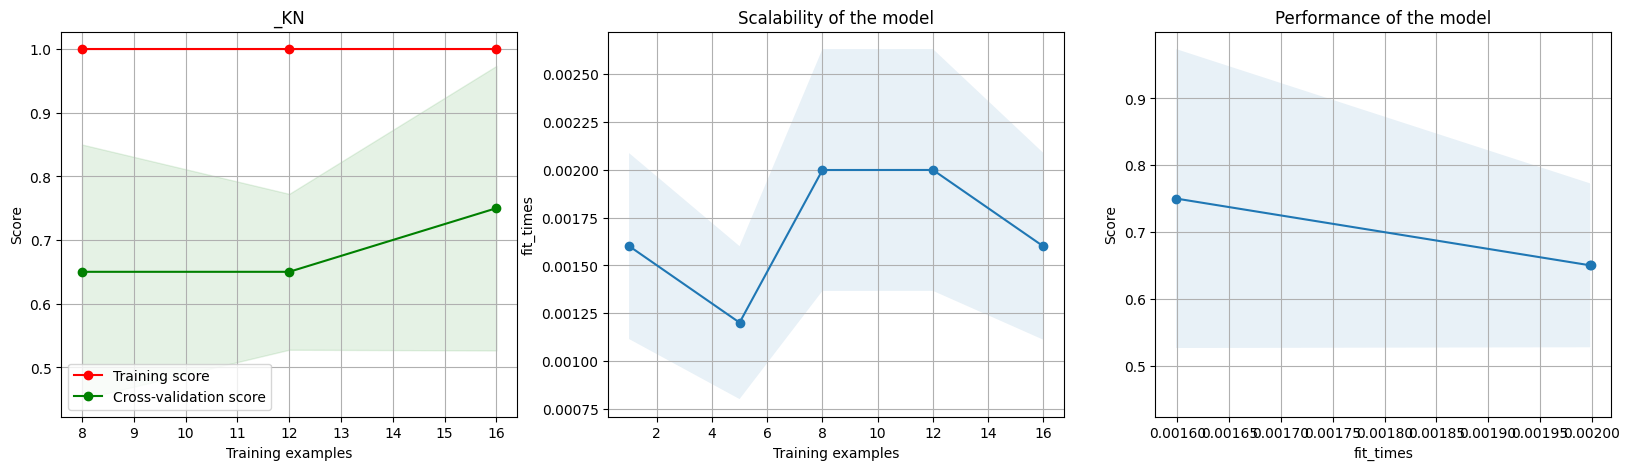

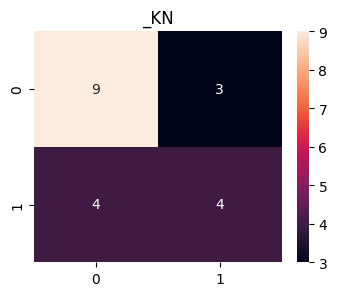

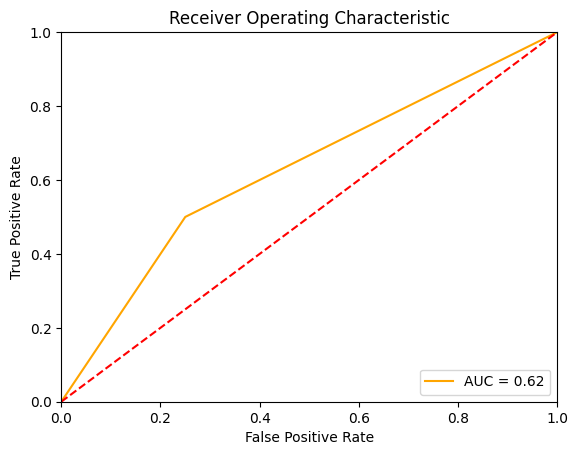

c:\Users\WMlab\.pyenv\pyenv-win\versions\3.11.4\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\WMlab\.pyenv\pyenv-win\versions\3.11.4\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\WMlab\.pyenv\pyenv-win\versions\3.11.4\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\WMlab\.pyenv\pyenv-win\version

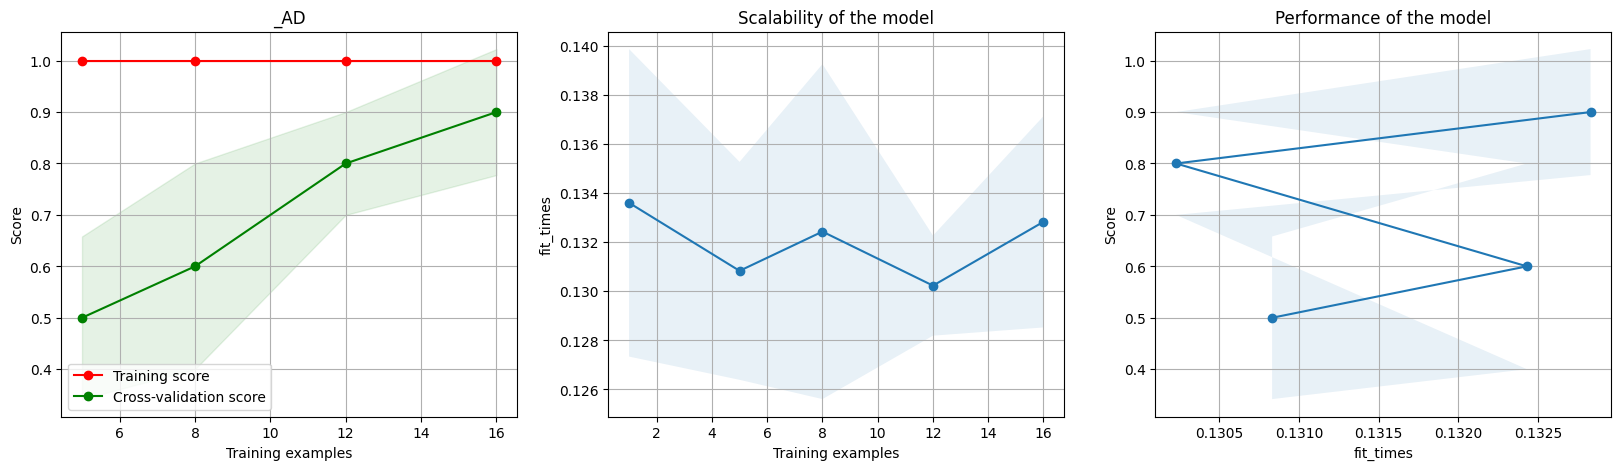

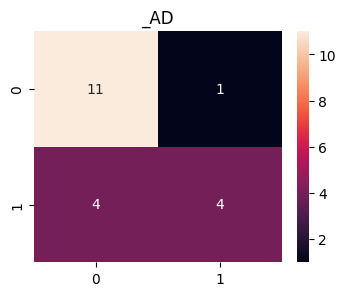

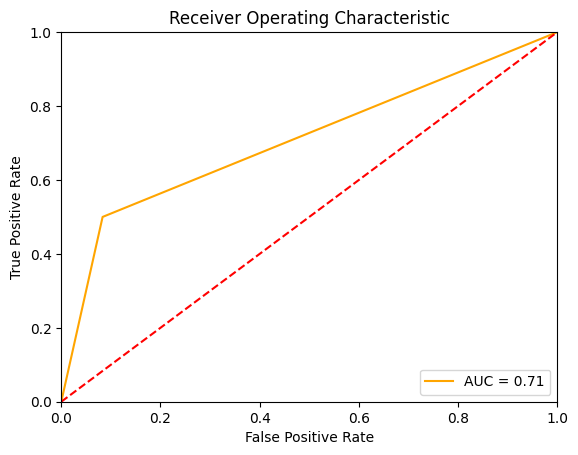

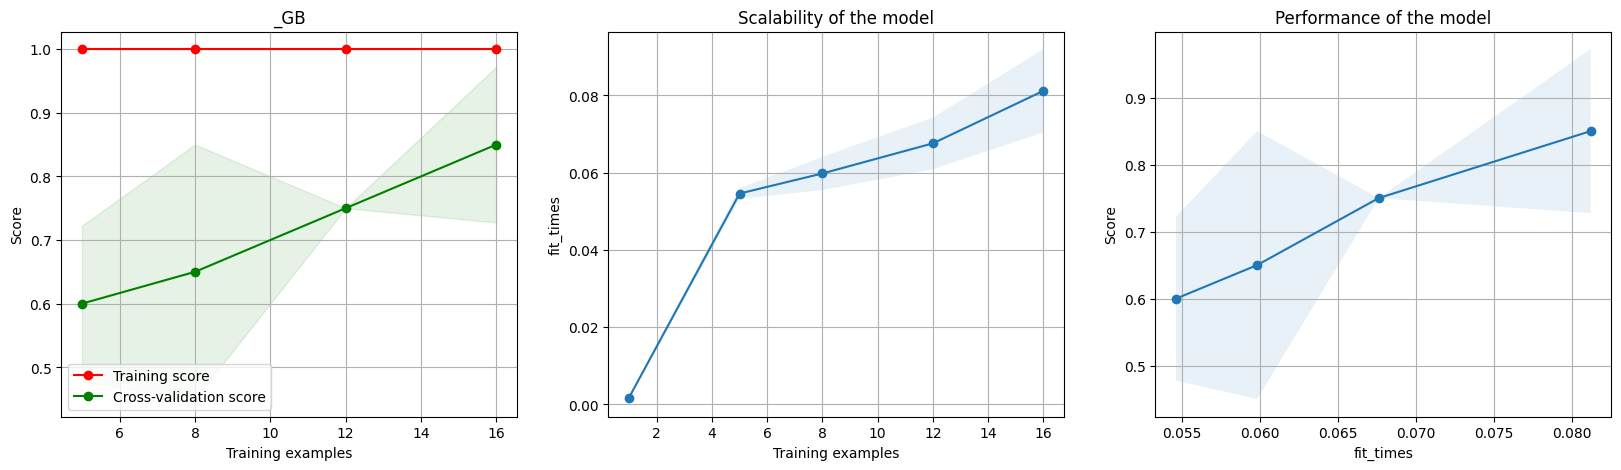

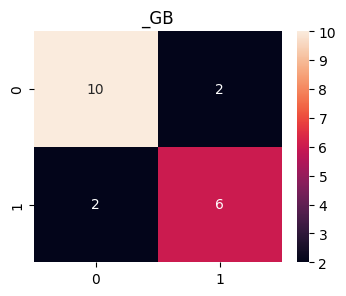

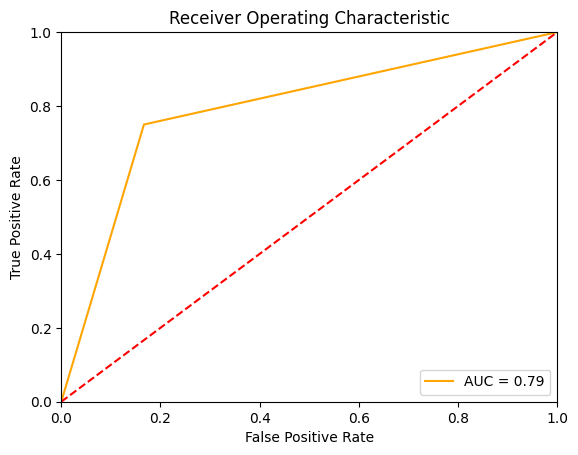

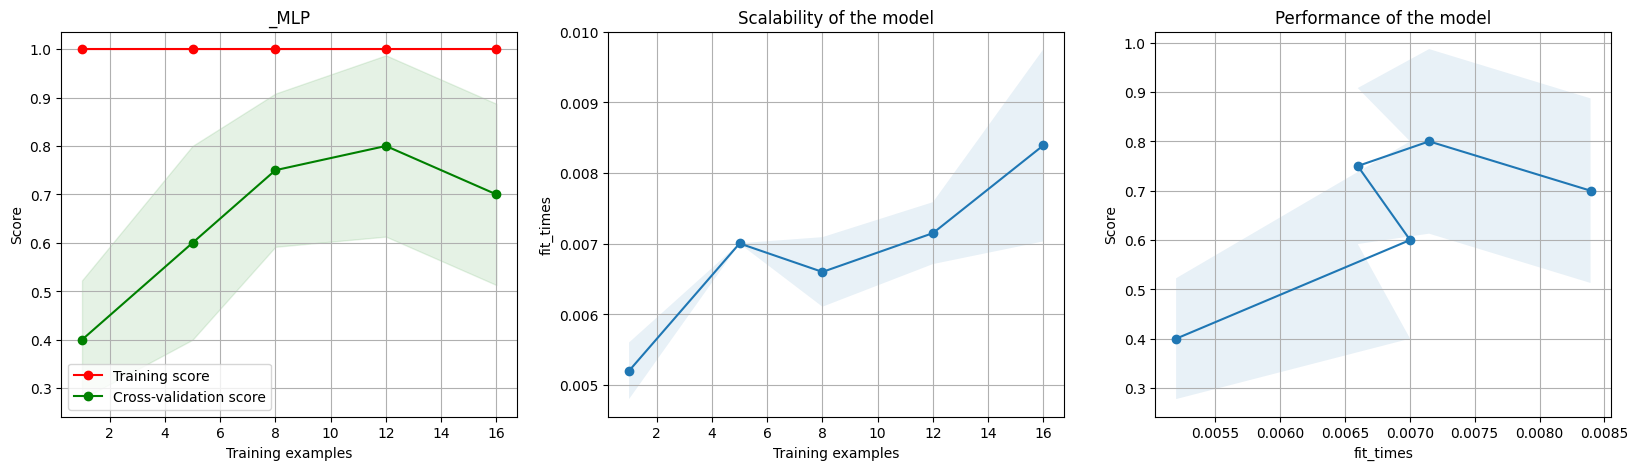

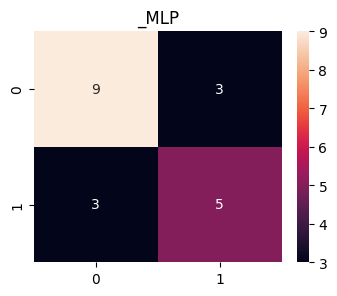

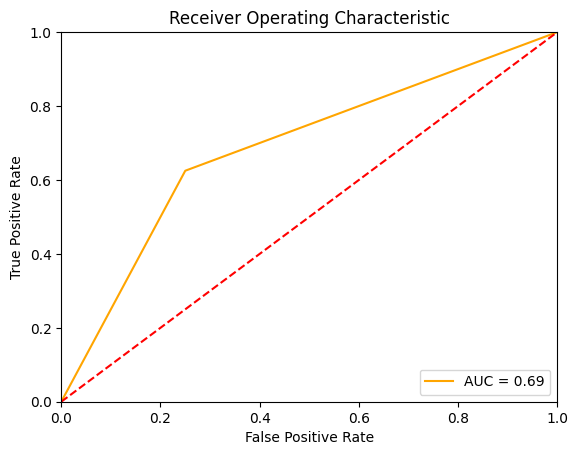

In [33]:
#A vs N pre Accuracy
for dataset in datasets:
    for selectModel in selectModels:
         # addictLabel 1A 0N stateLabel 0pre 2post
        group1_1 = {'addictLabel':1, 'stateLabel':2}
        group1_2 = None
        group2_1 = {'addictLabel':0, 'stateLabel':2}
        group2_2 = None
        trainModel(dataset, group1_1, group1_2, group2_1, group2_2, selectModel)

In [10]:
# #A1 vs N 各次VR Accuracy
# for dataset in datasets:
#     for selectModel in selectModels:
#         group1_1 = {'trainingCount':1,'addictLabel':1, 'stateLabel':1}
#         group1_2 = None
#         group2_1 = {'trainingCount':1,'addictLabel':0, 'stateLabel':1}
#         group2_2 = None
#         trainModel(dataset, group1_1, group1_2, group2_1, group2_2, selectModel)

In [11]:
# #A6 vs N 各次VR Accuracy
# for dataset in datasets:
#     for selectModel in selectModels:
#         group1_1 = {'trainingCount':6,'addictLabel':1, 'stateLabel':1}
#         group1_2 = None
#         group2_1 = {'trainingCount':1,'addictLabel':0, 'stateLabel':1}
#         group2_2 = None
#         trainModel(dataset, group1_1, group1_2, group2_1, group2_2, selectModel)

In [12]:
# #繪製A1pre vs A1~6 各次post Accuracy
# for dataset in datasets:
#     for trainingCount in [1,2,3,4,5,6]:
#         group1_1 = {'trainingCount':1,'addictLabel':1, 'stateLabel':0}
#         group1_2 = None
#         group2_1 = {'trainingCount':trainingCount,'addictLabel':1, 'stateLabel':2}
#         group2_2 = None
#         trainModel(dataset, group1_1, group1_2, group2_1, group2_2, None)

In [13]:

# group1_1 = {'trainingCount':1,'addictLabel':1, 'stateLabel':0}
# group1_2 = None
# group2_1 = {'trainingCount':1,'addictLabel':1, 'stateLabel':2}
# group2_2 = None
# trainModel('HRV', group1_1, group1_2, group2_1, group2_2, None)

In [14]:
# #A1 pre vs A6 post Fusion Accuracy
# for trainingCount in [1,6]:
#     for selectModel in selectModels:
#         group1_1 = {'trainingCount':trainingCount,'addictLabel':1, 'stateLabel':0}
#         group1_2 = None
#         group2_1 = {'trainingCount':trainingCount,'addictLabel':1, 'stateLabel':2}
#         group2_2 = None
#         trainModel('fusion', group1_1, group1_2, group2_1, group2_2, selectModel)

In [15]:
# #A6 vs N 各次pre post Accuracy
# for dataset in datasets:
#     for selectModel in selectModels:
#         for stage in [0, 2]:
#             group1_1 = {'trainingCount':6,'addictLabel':1, 'stateLabel':stage}
#             group1_2 = None
#             group2_1 = {'trainingCount':1,'addictLabel':0, 'stateLabel':stage}
#             group2_2 = None
#             trainModel(dataset, group1_1, group1_2, group2_1, group2_2, selectModel)

In [16]:
# #繪製A1 vs N 各次pre post Accuracy
# for dataset in datasets:
#     for selectModel in selectModels:
#         for stage in [0, 2]:
#             group1_1 = {'trainingCount':1,'addictLabel':1, 'stateLabel':stage}
#             group1_2 = None
#             group2_1 = {'trainingCount':1,'addictLabel':0, 'stateLabel':stage}
#             group2_2 = None
#             trainModel(dataset, group1_1, group1_2, group2_1, group2_2, selectModel)
                